# 0. Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from metrics import forecast_profit_score, rmse, mape
from pathlib import Path

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV

from sktime.forecasting.compose import DirectTabularRegressionForecaster
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sktime.transformations.compose import TransformerPipeline
from sktime.transformations.panel.compose import ColumnTransformer
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.cos import CosineTransformer
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.summarize import WindowSummarizer

from xgboost import XGBRegressor, XGBClassifier

# 1. Data preparation

In [2]:
df = pd.read_parquet("final_data.parquet")

In [3]:
df["Range"] = (
    np.log(df["High"]) - np.log(df["Low"])
)

In [4]:
def get_lag_creator(df, **kwargs):
    for column, lags in kwargs.items():
        for lag in lags:
            df = df.assign(**{f"{column}_l{lag}": lambda _df: _df[column].shift(lag)})
    df.drop(columns = kwargs.keys(), inplace = True)
    return df

In [5]:
price_transformer = TransformerPipeline(
    [("log", LogTransformer()), ("differce", Differencer(lags=1, drop_na=True))]
)

col_transformer = ColumnTransformer(
    [
        ("price", price_transformer, ["Close", "Open", "High", "Low"]),
        ("trading", LogTransformer(), ["Volume", "Range"]),
        (
            "time",
            CosineTransformer(),
            ["month", "day", "dayofweek"],
        ),
        ("forum", Differencer(lags=1, drop_na=True), ["comment_count"]),
    ]
)

kwargs = {
    "target_cols": [
        "Open",
        "High",
        "Low",
        "Volume",
        "comment_count",
        "month",
        "day",
        "dayofweek",
        "Range",
    ],
    "lag_config": {
        "lag": ["lag", [[0, l] for l in range(7)]],
    },
}

transformer_pipe = TransformerPipeline([("column", col_transformer)])

In [6]:
transformed_df = col_transformer.fit_transform(
    X=df.dropna().reset_index(drop=True)
).dropna()

In [7]:
lagged_df = get_lag_creator(
    transformed_df,
    **{
        c: [*range(1, 15)]
        for c in [
            "Open",
            "High",
            "Low",
            "Volume",
            "comment_count",
            "month",
            "day",
            "dayofweek",
            "Range",
        ]
    },**{'Close': [*range(0,15)]}
).dropna()

In [8]:
y_test = lagged_df["Close_l0"]

In [9]:
# for classification
lagged_df["Close_l0"] = lagged_df["Close_l0"].apply(lambda x: 1 if x >= 0 else 0)

In [10]:
y = lagged_df["Close_l0"]
X = lagged_df.drop(columns=["Close_l0"])
# Use this if you don't want to include the forum data
# .loc[:, ~lagged_df.columns.str.startswith("comment_")]

# 2. XGBoost Classifier - Hyperparameter tuning

* Az első 500 napon paraméter optimalizálunk grid search-el

In [25]:
train_data_x = X[:500]
train_data_y = y[:500]

In [60]:
xgb_classifier = XGBClassifier(
    learning_rate=0.1,
    n_estimators=160,
    max_depth=2,
    min_child_weight=10,
    gamma=0,
    n_jobs=1,
    eval_metric=f1_score,
    random_state=42,
)

In [47]:
param_test1 = {
    "max_depth": [2, 3, 4, 5],
    "min_child_weight": [8, 9, 10],
    "learning_rate": [*np.arange(0, 0.11, 0.01)],
    "min_child_weight": [8, 9, 10],
}


gsearch1 = GridSearchCV(estimator=xgb_classifier, param_grid=param_test1,)
gsearch1.fit(train_data_x, train_data_y)

print(gsearch1.best_estimator_) 
print(gsearch1.best_params_) 
print(gsearch1.best_score_)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric=<function f1_score at 0x15601d680>,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=2,
                                     max_leaves=None, min_child_weight=3,
                                     mis

In [ ]:
xgb_classifier = xgb_classifier.set_params(**gsearch1.best_params_)

# 3. Feature importance
* Az első 500 napon (2év) tanított modell alapján

In [62]:
xgb_classifier.fit(train_data_x, train_data_y)
y_pred = xgb_classifier.predict_proba(X[501:600], iteration_range=(0, 10))

Text(0, 0.5, 'Top 20 Features (X)')

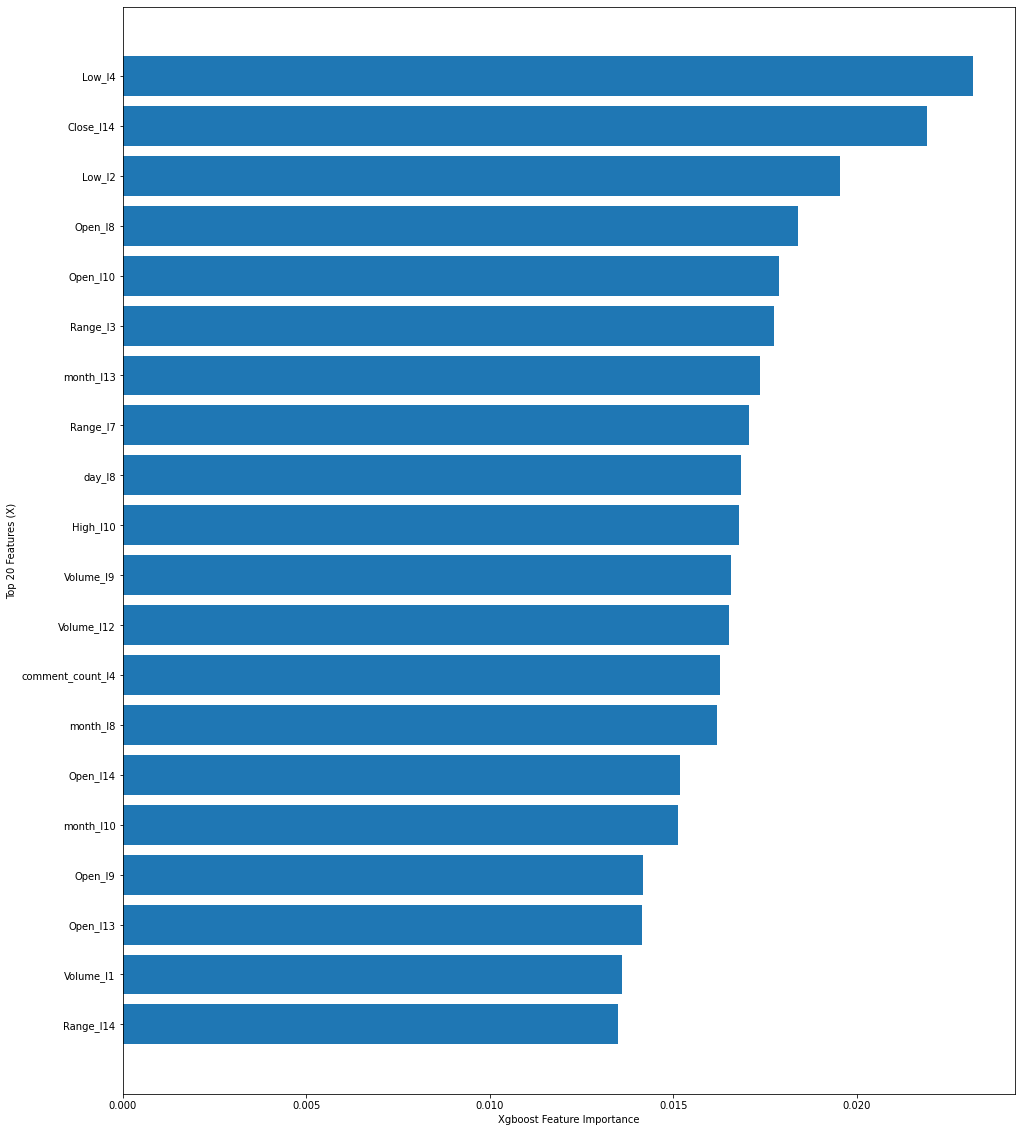

In [102]:
fig, ax = plt.subplots(figsize=(16, 20))
sorted_idx = xgb_classifier.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx][120:140], xgb_classifier.feature_importances_[sorted_idx][120:140])
plt.xlabel("Xgboost Feature Importance")
plt.ylabel("Top 20 Features (X)")

# 4. XGBoost Classifier
* Az első 500 napon futtatott modellen optimalizált paraméterekkel
* 1 napot prediktálunk előre, az előtte lévő 252 nap alapján
* Predikció kiértékelése (Cash & Accuracy)

In [ ]:
min_time = 501
train_period = 252
predictions = []

In [12]:
for i in range(len(y)):

    X_train = X[min_time + i : min_time + train_period + i]
    y_train = y[min_time + i : min_time + train_period + i]
    X_test = X[min_time + i : min_time + train_period + i + 1]

    xgb_classifier.fit(X_train, y_train)
    y_pred = xgb_classifier.predict_proba(X_test, iteration_range=(0, 10))
    predictions.append(y_pred[-1])

    if min_time + train_period + i + 1 == len(y) - 1:
        break

In [13]:
predictions = [i[0] for i in predictions]
result_df = pd.DataFrame(y_test[min_time + 1 : len(y_test)])
result_df["y_pred"] = predictions

,Close_l0,y_pred
3623,-0.002070,0.475597
3624,0.021630,0.741688
3625,0.002416,0.653027
3626,0.007448,0.608451
3627,-0.006957,0.446749
...,...,...
3869,-0.020977,0.382718
3870,-0.010263,0.464937
3871,0.006369,0.316430
3872,0.033462,0.339045


In [14]:
def kiertekelem(ert_df):

    ert_df = ert_df.copy()
    ert_df["y_pred"] = ert_df["y_pred"].apply(lambda x: 1 if x > cut_of else 0)

    # calculate loss
    ert_df.loc[(ert_df["Close_l0"] > 0) & (ert_df["y_pred"] == 1), "cash"] = ert_df[
        "Close_l0"
    ]
    ert_df.loc[(ert_df["Close_l0"] > 0) & (ert_df["y_pred"] == 0), "cash"] = ert_df[
        "Close_l0"
    ].apply(lambda y: -y if y > -0.05 else -0.05)
    ert_df.loc[(ert_df["Close_l0"] < 0) & (ert_df["y_pred"] == 0), "cash"] = -(
        ert_df["Close_l0"]
    )
    ert_df.loc[(ert_df["Close_l0"] < 0) & (ert_df["y_pred"] == 1), "cash"] = ert_df[
        "Close_l0"
    ].apply(lambda y: y if y > -0.05 else -0.05)

    # loss column to array
    return ert_df.cash.to_numpy()

In [15]:
eredmenyek = []

## Cut-off value

In [16]:
for i in range(1,10):
    cut_of= i/10 
    eredmenyek.append(np.sum(kiertekelem(result_df)))

<AxesSubplot:>

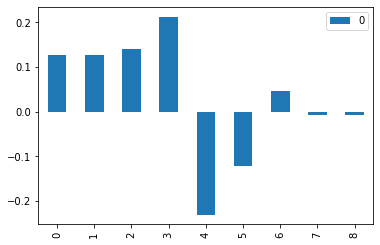

In [18]:
pd.DataFrame(eredmenyek).plot.bar()

## Confusion matrix

In [20]:
y_true = list(y[3607+1:len(y)])
predictions = list(result_df["y_pred"].apply(lambda x: 1 if x>0.6 else 0))

In [21]:
conmat = confusion_matrix(y_true, predictions)
conmat

array([[ 90,  28],
       [109,  24]])

# 5. Trading strategy based on predicted probablity

In [ ]:
cv_df.to_pickle('../../data/processed/with_forum.pickle')

# (Regressor)

In [ ]:
xgb_regressor = XGBRegressor(
    n_estimators=150,
    max_depth=25,
    n_jobs=20,
    eval_metric=mape,
    random_state=42,
)

forecaster = DirectTabularRegressionForecaster(estimator=xgb_regressor, window_length=5)

In [ ]:
fh = ForecastingHorizon(values=1)
cv = SlidingWindowSplitter(fh=fh, step_length=1, window_length = 21*12, start_with_window=True)
cv_df = fit_predict(y, )
cv_df = evaluate(
    forecaster=forecaster,
    y=y,
    X=X,
    cv=cv,
    strategy="refit",
    scoring=rmse,
    return_data=True,
)

# Hyperparameter tuning

In [ ]:
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV

In [ ]:
nested_params = {
    "window_length": [5, 10, 15, 20, 25, 30],
    "estimator__max_depth": [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25],
    "estimator__n_estimators": [30, 50, 100, 150, 200, 250],
}

fh = ForecastingHorizon(values=1)
cv = SlidingWindowSplitter(fh=fh, step_length=12*21, window_length = 21*12, start_with_window=True)
# cv = ExpandingWindowSplitter(fh=fh, step_length=21, initial_window=21 * 9)
nrcv = ForecastingRandomizedSearchCV(
    forecaster,
    strategy="refit",
    cv=cv,
    param_distributions=nested_params,
    n_iter=1000,
    random_state=42,
    n_jobs=1,
    scoring=rmse,
    verbose=1,
)
nrcv.fit(y, fh=fh)

In [ ]:
import json
Path('best_params.json').write_text(json.dumps(nrcv.best_params_))

In [ ]:
feature_important = xgb.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
plt.figure(figsize= (12,10))
sns.barplot(x = data.score , y = data.index, orient = 'h', palette = 'Blues_r')